# ~ ~ ~ Spectral Diagnostics using IBIS data ~ ~ ~ 

### In this notebook

We will work with observations from a Fabry-Perot spectrometer made in three different spectral lines: 

- H$\alpha$, the classical, very NLTE chromospheric spectral line. It is very weakly coupled to the local atmospheric conditions due to scattering. It is sensitive to velocity, even if the core is often very "flat-bottomed", so noise is an issue. 

- Ca II 8542, another NLTE chromospheric spectral line (but more directly coupled to local temperature), with a narrower chromospheric core, which makes it more amenable to use as a magnetic field diagnostics. 

- Na I D 1, typically probing photosphere and temperature minimum, but with some response to plasma at greater heights. A typical NLTE line formed by scattering so it only yields temperature information about photospheric layers. Usable for velocity and magnetic field diagnostics in the lower atmosphere. 

### Of note, with respect yesterday's exercise with FISS:


- these are imaging spectrometer data, so due to the scanning limits of the passband, and in the interest of temporal cadence, the line is not sampled all the way to the true continuum in the broad chromospheric lines (though they do sample the portion of the wings formed in the chromosphere;

- the spatial resolution is sensibly higher (around diffraction limit for our data, ~ 0.2" at Halpha; vs. a nominal 0.32" for FISS, but with longer exposures and no post-facto image correction, slit spectrographs often don't achieve optimal spatial resolution))

- we have a field of view of 95" x 95", or 68 x 68 Mm<sup>2</sup>, sampled in ~15 seconds for all three lines

In [1]:
# set directory on your machine where the data can be found

data_dir = '/Path/to/data/directory/data/Velocity_IBIS/'
data_dir = '/Users/gcauzzi/Level2/WFA_June2021_workshop/data/Velocity_IBIS/'

In [2]:
# We will import some basic packages:

from astropy.io import fits
import numpy as np 
import matplotlib.pyplot as plt 

from matplotlib import colors
from matplotlib.pyplot import *

from IPython.display import Markdown as md

# set this variable to the directory where the downloaded data can be found
#data_dir = '/Path/to/data/directory/data/Velocity_IBIS/'


### Load H$\alpha$ Spectral Data Cube

In [3]:
# First we will open the most dramatic spectral line, H alpha

cube_halpha = fits.open(data_dir + "IBIS.Halpha.fits")[0].data
cube_halpha=np.transpose(cube_halpha,[1,2,0])
ll_halpha = fits.open(data_dir + "IBIS.Halpha.wav.fits")[0].data
mean_spectrum_h = np.mean(cube_halpha,axis=(0,1))

center_pix = np.argmin(mean_spectrum_h)
(waverel_min, waverel_max) = np.min(ll_halpha - ll_halpha[center_pix]),np.max(ll_halpha - ll_halpha[center_pix])
wavesample_txt = "\n ### Wavelength sampling: {:0.2f} Å -- {:0.2f} Å in {:3} points".format(waverel_min, waverel_max, len(mean_spectrum_h))

wavesteps = np.gradient(ll_halpha)
(wavestep_ave, wavestep_min, wavestep_max) = np.mean(wavesteps),np.min(wavesteps),np.max(wavesteps)
wavestep_txt = "\n### Wavelength steps [average, min, max]: {:0.3f}, {:0.3f}, {:0.3f} Å".format(wavestep_ave, wavestep_min, wavestep_max)

md(wavesample_txt + wavestep_txt)


 ### Wavelength sampling: -1.92 Å -- 2.30 Å in  45 points
### Wavelength steps [average, min, max]: 0.096, 0.096, 0.096 Å

In [4]:
cube_ca = fits.open(data_dir + "IBIS.CaII.fits")[0].data
ll_ca = fits.open(data_dir + "IBIS.CaII.wav.fits")[0].data
cube_ca = np.transpose(cube_ca,[1,2,0])
mean_spectrum_ca = np.mean(cube_ca,axis=(0,1))

center_pix = np.argmin(mean_spectrum_ca)
(waverel_min, waverel_max) = np.min(ll_ca - ll_ca[center_pix]),np.max(ll_ca - ll_ca[center_pix])
wavesample_txt = "### Wavelength sampling: {:0.2f} Å -- {:0.2f} Å in {:3} points".format(waverel_min, waverel_max, len(mean_spectrum_ca))

wavesteps = np.gradient(ll_ca)
(wavestep_ave, wavestep_min, wavestep_max) = np.mean(wavesteps),np.min(wavesteps),np.max(wavesteps)
wavestep_txt = "\n### Wavelength steps [average, min, max]: {:0.3f}, {:0.3f}, {:0.3f} Å".format(wavestep_ave, wavestep_min, wavestep_max)

md(wavesample_txt + wavestep_txt)

### Wavelength sampling: -1.70 Å -- 1.99 Å in  75 points
### Wavelength steps [average, min, max]: 0.050, 0.050, 0.050 Å

In [5]:
cube_na = fits.open(data_dir + "IBIS.NaD1.fits")[0].data
ll_na = fits.open(data_dir + "IBIS.NaD1.wav.fits")[0].data
cube_na = np.transpose(cube_na,[1,2,0])
mean_spectrum_na = np.mean(cube_na,axis=(0,1))

center_pix = np.argmin(mean_spectrum_na)
(waverel_min, waverel_max) = np.min(ll_na - ll_na[center_pix]),np.max(ll_na - ll_na[center_pix])
wavesample_txt = "### Wavelength sampling: {:0.2f} Å -- {:0.2f} Å in {:3} points".format(waverel_min, waverel_max, len(mean_spectrum_na))

wavesteps = np.gradient(ll_na)
(wavestep_ave, wavestep_min, wavestep_max) = np.mean(wavesteps),np.min(wavesteps),np.max(wavesteps)
wavestep_txt = "\n### Wavelength steps [average, min, max]: {:0.3f}, {:0.3f}, {:0.3f} Å".format(wavestep_ave, wavestep_min, wavestep_max)

md(wavesample_txt + wavestep_txt)

### Wavelength sampling: -1.17 Å -- 1.08 Å in 132 points
### Wavelength steps [average, min, max]: 0.017, 0.017, 0.017 Å

## Finding velocities as the line center position shift

We know this method well by now, but let's just use it on the whole map and all three lines. 
Let's define the usual little module, with some extra tweaks to:
- allow us to specify how many points to fit around the core; 
- display the fitted polynomial as a sanity check; 
- return also the intensity of the parabola minimum).

In [6]:
def calc_line_center(spectrum, wavelength, showplot=0, fit_range=3):
    
    indmin = np.argmin(spectrum) #Index of the point with minimum intensity:
    
    # Fit a parabola (polynomial of degree 2, through a few of points each side of center)
    # Careful that this might depend on the actual sampling of your line and/or how steep the wings are
    p = np.polyfit(wavelength[indmin-fit_range:indmin+fit_range+1],spectrum[indmin-fit_range:indmin+fit_range+1],2)

    l_center = -p[1]/2/p[0]
    l_center_int = p[0] * l_center**2 + p[1] * l_center**1 + p[2] * l_center**0
    
    if showplot >= 1:
        plt.figure(figsize=[10,10])
        plt.plot(wavelength[indmin-fit_range:indmin+fit_range+1],spectrum[indmin-fit_range:indmin+fit_range+1],"-x")

        wavelength_fine = np.arange(wavelength[indmin-fit_range],wavelength[indmin+fit_range]+0.002,0.002)
        plt.plot(wavelength_fine,(p[0] * wavelength_fine**2 + p[1] * wavelength_fine**1 + p[2]))
        plt.plot(l_center, l_center_int,"o")
    
    return (l_center, l_center_int)

fit points:  3
Line center wavelength: 6562.7647 Å
Line center intensity: 0.1541


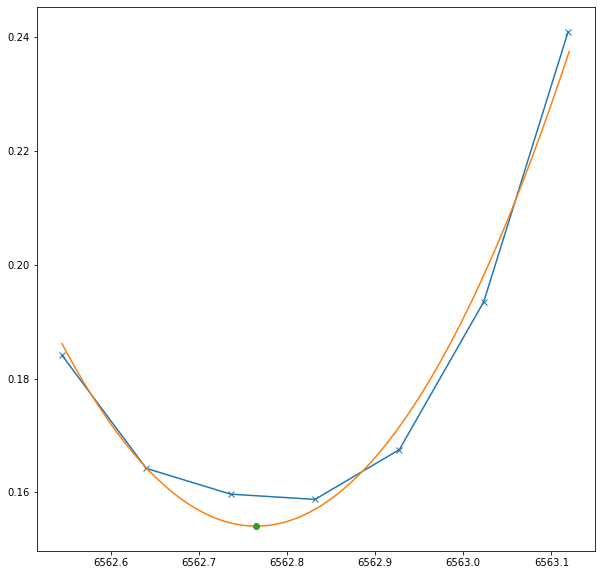

In [7]:
# Let's try on a random IBIS spectrum and see if it makes sense: 

#lcints = np.zeros([9])
#lcpos = np.zeros([9])

for fitran in range (3,4):
    (l_center_random, l_center_int) = calc_line_center(cube_halpha[633,349],ll_halpha,showplot=1, fit_range=fitran)

    #lcints[fitran-1] = l_center_int
    #lcpos[fitran-1] = l_center_random
    print("fit points: ", fitran)
    print ("Line center wavelength: {:0.4f} Å".format(l_center_random))
    print ("Line center intensity: {:0.4f}".format(l_center_int))

#plt.plot(range(1,10), np.gradient(lcints),"-o")
#plt.plot(range(1,10), np.gradient(lcpos)/6563*3e5,"-o")

In [9]:
# we calculate the line-minimum wavelength from the average spectrum
(l_center_mean_ha, l_center_int) = calc_line_center(mean_spectrum_h,ll_halpha,showplot=0)
ll0 = l_center_mean_ha

# Looks reasonable, what velocity would this be? 
c = 2.997E5 # in km/s
v_test = (l_center_random-l_center_mean_ha)/l_center_mean_ha *c 

print ("Measured wavelength shift","{:0.3f} Å".format(l_center_random-l_center_mean_ha))
print ("Equivalent velocity","{:0.3f} km/s".format(v_test))

Measured wavelength shift -0.022 Å
Equivalent velocity -1.015 km/s


### Now let's measure the line center positions for the full field, starting with H$\alpha$

In [9]:
line_centers_h = np.zeros([1000,1000])
line_ints_h    = np.zeros([1000,1000])

for i in range(0,1000):
    for j in range(0,1000):
        (line_centers_h[i,j], line_ints_h[i,j]) = calc_line_center(cube_halpha[i,j],ll_halpha)

vhalpha_line_center = (line_centers_h - l_center_mean_ha)/l_center_mean_ha * c

Text(0, 0.5, 'y [pix]')

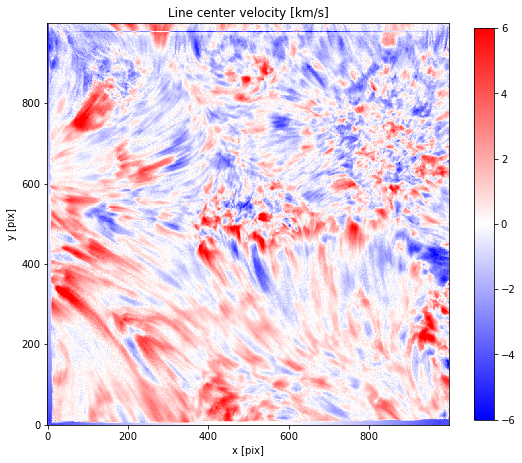

In [10]:
# And let's plot the velocity map
plt.figure(figsize=[9,9])
plt.imshow(vhalpha_line_center,vmin=-6,vmax=6,cmap='bwr',origin='lower')
plt.colorbar(shrink=0.8)
plt.title("Line center velocity [km/s]")
plt.xlabel("x [pix]")
plt.ylabel("y [pix]")

Text(0.5, 0, 'x [pix]')

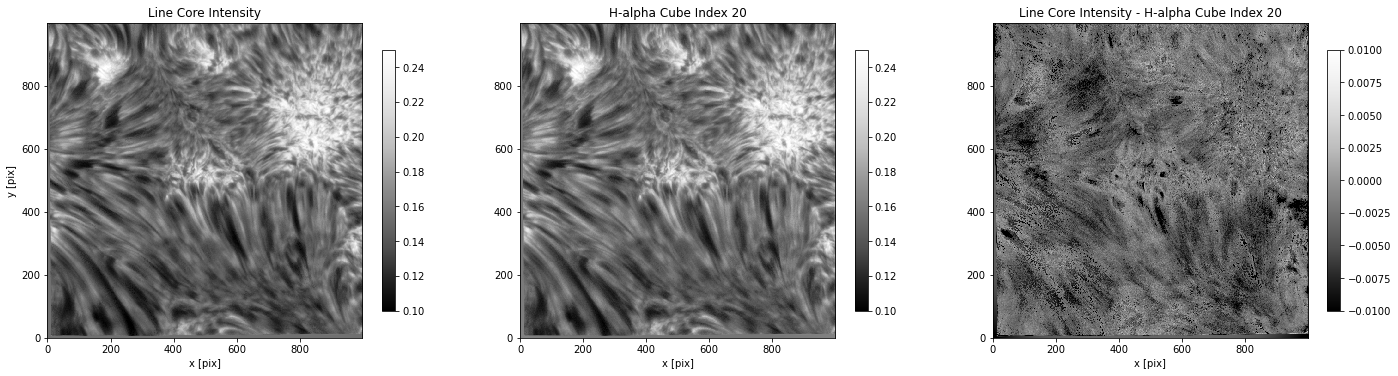

In [11]:
mean_spectrum_min_idx = np.argmin(abs(ll_halpha - l_center_mean_ha))
plt.figure(figsize=[24,24])

plt.subplot(131)
plt.imshow(line_ints_h,cmap='Greys_r',origin='lower',vmin=0.1,vmax=0.25)
plt.colorbar(shrink=0.2)
plt.title("Line Core Intensity")
plt.xlabel("x [pix]")
plt.ylabel("y [pix]")

plt.subplot(132)
plt.imshow(cube_halpha[:,:,mean_spectrum_min_idx],cmap='Greys_r',origin='lower',vmin=0.1,vmax=0.25)
plt.colorbar(shrink=0.2)
plt.title("H-alpha Cube Index {:2}".format(mean_spectrum_min_idx))
plt.xlabel("x [pix]")
#plt.ylabel("y [pix]")

plt.subplot(133)
plt.imshow(line_ints_h - cube_halpha[:,:,mean_spectrum_min_idx],cmap='Greys_r',origin='lower', vmin=-0.01,vmax=0.01)
plt.colorbar(shrink=0.2)
plt.title("Line Core Intensity - H-alpha Cube Index {:2}".format(mean_spectrum_min_idx))
plt.xlabel("x [pix]")
#plt.ylabel("y [pix]")

### Let's spend some time discussing this. 

- What amplitudes do we get ? (remember the FISS values?)
- What kind of features are most visible ? 
- Do particular features always have the same velocities?
.
.
#### We have two other lines, let's do the same & compare

### And now Ca II 8542 and Na D<sub>1</sub> 5896 Å

In [10]:
(ca8542_mean_line_wave, ca8542_mean_line_int) = calc_line_center(mean_spectrum_ca,ll_ca, showplot=0)

print ("Line center wavelength: {:0.4f} Å".format(ca8542_mean_line_wave))
print ("Line center intensity: {:0.4f}".format(ca8542_mean_line_int))

Line center wavelength: 8542.1114 Å
Line center intensity: 0.1936


In [14]:
line_centers_ca = np.zeros([1000,1000])
line_ints_ca    = np.zeros([1000,1000])

for i in range(0,1000):
    for j in range(0,1000):
        (line_centers_ca[i,j],line_ints_ca[i,j]) = calc_line_center(cube_ca[i,j],ll_ca)

vca_line_center = (line_centers_ca - ca8542_mean_line_wave)/ca8542_mean_line_wave * c   


Line center wavelength: 5895.9209 Å
Line center intensity: 0.0622


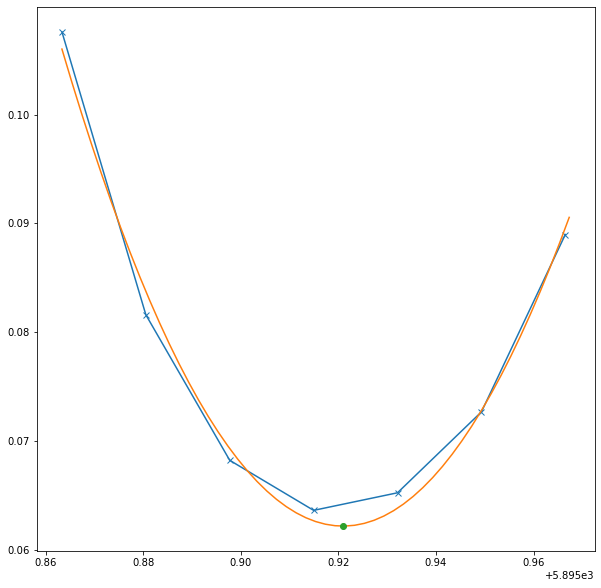

In [11]:
(na5896_mean_line_wave, na5896_mean_line_int) = calc_line_center(mean_spectrum_na,ll_na,showplot=1)

print ("Line center wavelength: {:0.4f} Å".format(na5896_mean_line_wave))
print ("Line center intensity: {:0.4f}".format(na5896_mean_line_int))

In [16]:
line_centers_na = np.zeros([1000,1000])
line_ints_na    = np.zeros([1000,1000])

for i in range(0,1000):
    for j in range(0,1000):
        (line_centers_na[i,j], line_ints_na[i,j]) = calc_line_center(cube_na[i,j],ll_na)

vna_line_center = (line_centers_na - na5896_mean_line_wave)/na5896_mean_line_wave * c    #

#### Fitting the line core gives us both a more accurate position (velocity) and also intensity (no velocity cross talk)

Text(0.5, 1.0, 'Ca II 8542 Line Core Velocity')

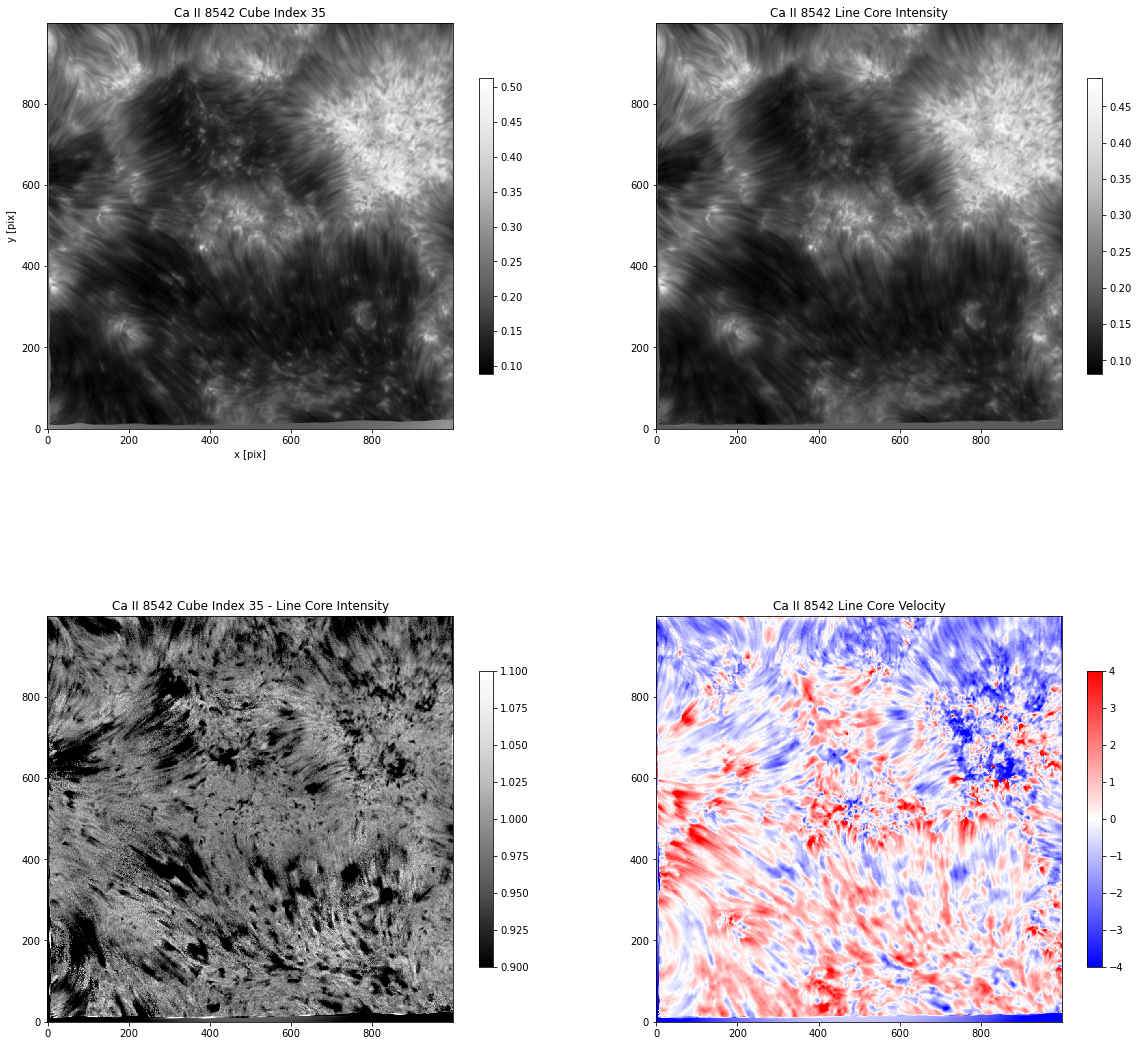

In [74]:
mean_spectrum_ca_min_idx = np.argmin(abs(ll_ca - ca8542_mean_line_wave)) + 1
plt.figure(figsize=[20,20])

plt.subplot(221)
plt.imshow(cube_ca[:,:,mean_spectrum_ca_min_idx],cmap='Greys_r',origin='lower')
plt.colorbar(shrink=0.6)
plt.title("Ca II 8542 Cube Index {:2}".format(mean_spectrum_ca_min_idx))
plt.xlabel("x [pix]")
plt.ylabel("y [pix]")

plt.subplot(222)
plt.imshow(line_ints_ca,cmap='Greys_r',origin='lower')
plt.colorbar(shrink=0.6)
plt.title("Ca II 8542 Line Core Intensity")

plt.subplot(223)
plt.imshow(line_ints_ca / cube_ca[:,:,mean_spectrum_ca_min_idx],cmap='Greys_r',origin='lower', vmin=0.9,vmax=1.1)
plt.colorbar(shrink=0.6)
plt.title("Ca II 8542 Cube Index {:2} - Line Core Intensity".format(mean_spectrum_ca_min_idx))

plt.subplot(224)
plt.imshow(vca_line_center,cmap='bwr',origin='lower', vmin=-4,vmax=4)
plt.colorbar(shrink=0.6)
plt.title("Ca II 8542 Line Core Velocity")


**All maps scaled to $\pm$ 6 km/sec**

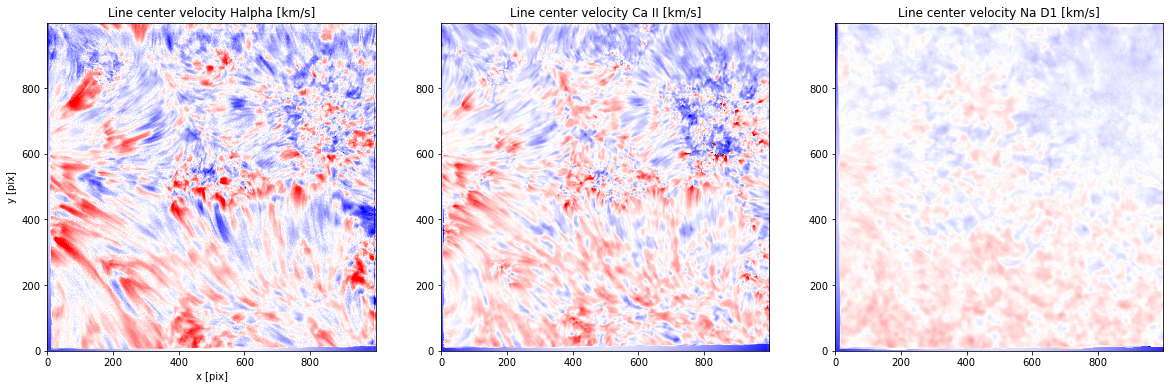

In [24]:
# And let's plot the velocity maps

plt.figure(figsize=[20,9])

plt.subplot(131)
plt.imshow(vhalpha_line_center-np.mean(vhalpha_line_center),vmin=-6,vmax=6,cmap='bwr',origin='lower')
#plt.colorbar(shrink=0.8)
plt.title("Line center velocity Halpha [km/s]")
plt.xlabel("x [pix]")
plt.ylabel("y [pix]")

plt.subplot(132)
plt.imshow(vca_line_center-np.mean(vca_line_center),vmin=-6,vmax=6,cmap='bwr',origin='lower')
#plt.colorbar(shrink=0.8)
plt.title("Line center velocity Ca II [km/s]")

plt.subplot(133)
plt.imshow(vna_line_center-np.mean(vna_line_center),vmin=-6,vmax=6,cmap='bwr',origin='lower')
#plt.colorbar(shrink=0.5)
plt.title("Line center velocity Na D1 [km/s]")
done=1
md("**All maps scaled to $\pm$ 6 km/sec**")

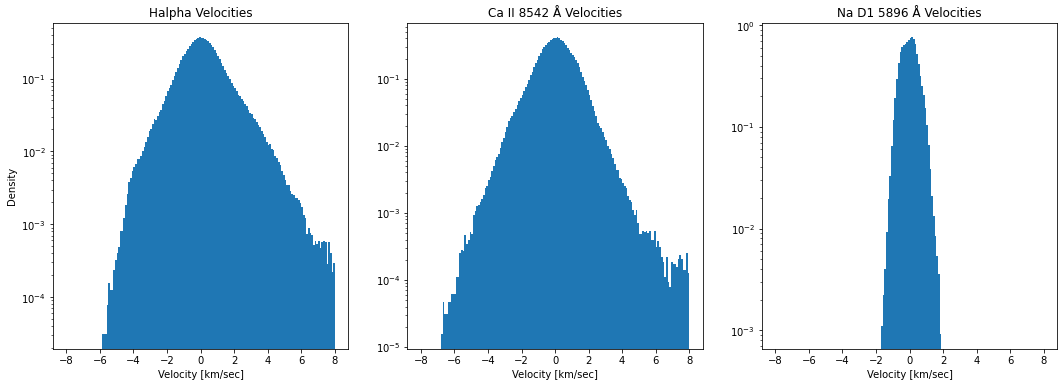

In [31]:
#Let's see a histogram/distribution?

# cutbox defines the sub-region which to consider in these histograms and following sections
# certainly we want to cut off the edges of the field where we have some "bad" values
# due to image motion, but it could also let us focus on specific targets or features
cutbox = [100,900,100,900] 
# set to any non-null value to see histograms in logarithmic scale
logplot = '1'
hist_range = [-8,8]  # km/sec
hist_step  = 0.1     # km/sec
hist_bins = int((hist_range[1] - hist_range[0]) / hist_step)

plt.figure(figsize=[18,6])

plt.subplot(131)
counts = plt.hist(vhalpha_line_center[cutbox[0]:cutbox[1],cutbox[2]:cutbox[3]].flatten(),hist_bins,range=hist_range,density=1,log=logplot)
plt.title("Halpha Velocities")
plt.xlabel("Velocity [km/sec]")
plt.ylabel("Density")

plt.subplot(132)
counts = plt.hist(vca_line_center[cutbox[0]:cutbox[1],cutbox[2]:cutbox[3]].flatten(),hist_bins,range=hist_range,density=1,log=logplot)
plt.title("Ca II 8542 Å Velocities")
plt.xlabel("Velocity [km/sec]")

plt.subplot(133)
counts = plt.hist(vna_line_center[cutbox[0]:cutbox[1],cutbox[2]:cutbox[3]].flatten(),hist_bins,range=hist_range,density=1,log=logplot)
plt.title("Na D1 5896 Å Velocities")
plt.xlabel("Velocity [km/sec]")
done=1

### Discussion ?

1. Do we see the same features in all 3 lines?
2. How about the amplitudes?
3. (why that funny pattern of blue on top - red on bottom?)


### Are these velocities correlated ?


H-alpha to Ca II 8542 Velocity Correlation:  +0.5061
H-alpha to Na D1 5896 Velocity Correlation:  +0.2140


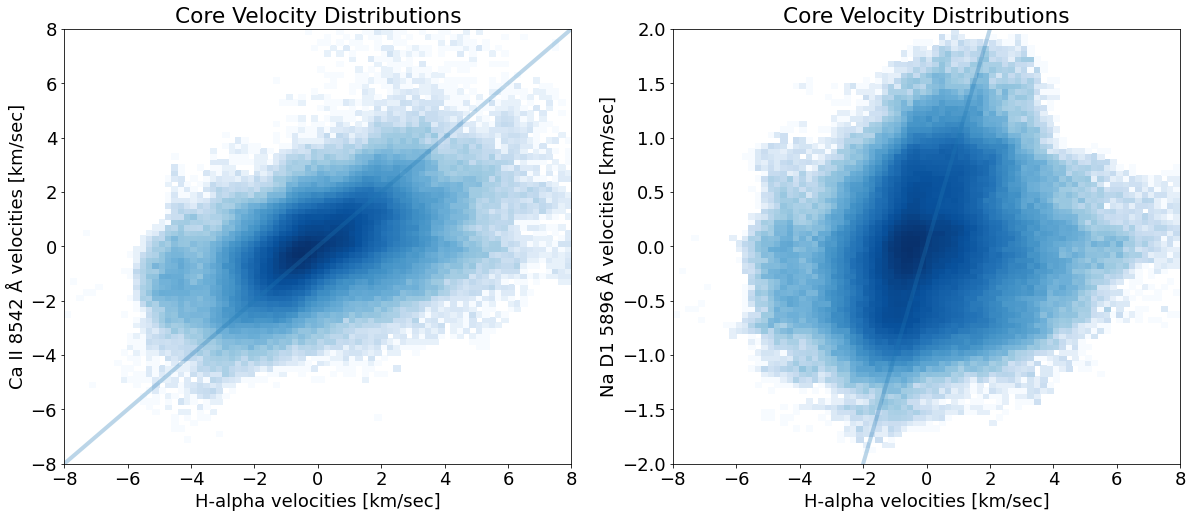

In [24]:
# Let's plot a fancy scatterplot.....

from matplotlib import colors
from matplotlib.pyplot import *
plt.rcParams.update({'font.size': 18})

vhalpha_1d = vhalpha_line_center[cutbox[0]:cutbox[1],cutbox[2]:cutbox[3]].flatten()
vca_1d     = vca_line_center[cutbox[0]:cutbox[1],cutbox[2]:cutbox[3]].flatten()
vna_1d     = vna_line_center[cutbox[0]:cutbox[1],cutbox[2]:cutbox[3]].flatten()

vhalpha_1d = vhalpha_1d - np.mean(vhalpha_1d)
vca_1d = vca_1d - np.mean(vca_1d)
vna_1d = vna_1d - np.mean(vna_1d)

plt.figure(figsize=[20,8])
plt.subplot(121)

counts,ybins,xbins,image = plt.hist2d(vhalpha_1d,vca_1d,bins=80,norm=colors.LogNorm(),range=[[-8,8],[-8,8]], cmap='Blues')
#contours = contour(xbins[1:],ybins[1:],counts,extent=[ybins.min(),ybins.max(),xbins.min(),xbins.max()],linewidths=1, alpha=0.5, levels=[10,100,1000])
#plt.clabel(contours, inline=True, fontsize=8)

plt.title("Core Velocity Distributions")
plt.xlabel("H-alpha velocities [km/sec]")
plt.ylabel("Ca II 8542 Å velocities [km/sec]")
plt.plot(range(-8,8+1,1),range(-8,8+1,1),alpha=0.3,linewidth=4)

plt.subplot(122)
counts,ybins,xbins,image = plt.hist2d(vhalpha_1d,vna_1d,bins=80,norm=colors.LogNorm(),range=[[-8,8],[-2,2]], cmap='Blues')
#contours = contour(counts,extent=[ybins.min(),ybins.max(),xbins.min(),xbins.max()],linewidths=1, alpha=0.5, levels=[10,100,1000],origin='lower')
#plt.clabel(contours, inline=True, fontsize=8)

plt.title("Core Velocity Distributions")
plt.xlabel("H-alpha velocities [km/sec]")
plt.ylabel("Na D1 5896 Å velocities [km/sec]")
plt.plot(range(-8,8+1,1),range(-8,8+1,1),alpha=0.3,linewidth=4)

print("H-alpha to Ca II 8542 Velocity Correlation: ","{:+0.4f}".format((np.corrcoef(vhalpha_1d,vca_1d))[0,1]))
print("H-alpha to Na D1 5896 Velocity Correlation: ","{:+0.4f}".format((np.corrcoef(vhalpha_1d,vna_1d))[0,1]))

#### The Sodium core velocity bears almost no resemblance to the Halpha one. 

#### The CaII core velocity instead is very well correlated with the Halpha ones,  but has consistently lower amplitudes


## Finding velocity via bisectors

### By now, you know the drill ....

The core velocity tells us mostly about the upper layers sampled by the lines, yet asymmetries are also important, as they can be the tell tale of velocity gradients within larger spans of the atmosphere. Or, if we want to go the "spicule" route, they can alert us about the presence of oddities in the wings, to be looked at more carefully

So, let's just take the module from yesterday, and run it all again ! The data is much bigger, so this will take a lot longer .....


In [12]:
# This will return position of left & right. With those values, one can then calculate 
# both the bisector position [wavelength] and width.


def calc_bisectors(spectrum,wavelength,levels,offset):
    # this is the function that takes in the spectrum, wavelength and desired bisector levels
    # and returns the position of both left & right points on the horizontal line that "cuts"
    # the profile at those levels.
    # Note: the levels are in fraction of the "Delta" between the line core and a position in the wings 
    # identified by the value "offset" = ~ 1 Ang for Halpha; 0.5 Ang for CaII

    from scipy.interpolate import interp1d
    
    (line_core_pos, line_core_int) = calc_line_center(spectrum,wavelength)
    l_blue = line_core_pos - offset
    l_red  = line_core_pos + offset

    f = interp1d(wavelength,spectrum, kind='cubic')
    I_wingintensity_blue = f(l_blue)
    I_wingintensity_red  = f(l_red)

    I_wingintensity_mean = 0.5*(I_wingintensity_blue + I_wingintensity_red)
    I_coreintensity_min = f(line_core_pos)

    wing_core_intensity_diff = I_wingintensity_mean - I_coreintensity_min

    I_level = np.zeros(len(levels))
    for jj in range (0,len(levels)):
        I_level[jj] = I_coreintensity_min + wing_core_intensity_diff * levels[jj]

    blue_position = np.zeros(len(levels))
    red_position = np.zeros(len(levels))

    local_min = np.argmin(np.abs(wavelength-line_core_pos))
    
    f = interp1d(spectrum[:local_min+1],wavelength[:local_min+1])
    
    for jj in range (0,len(levels)):
        blue_position[jj] = f(I_level[jj])

    f = interp1d(spectrum[local_min-1:],wavelength[local_min-1:])

    for jj in range (0,len(levels)):
        red_position [jj] = f(I_level[jj])

    return blue_position, red_position, I_level, line_core_pos

In [13]:
levels = np.asarray([1.0,0.9,0.7,0.5,0.3,0.1])
bis50_idx = np.argmin(np.abs(levels - 0.5))

offset_ha = 1.1 # appropriate value for Halpha
offset_ca = 0.6 # appropriate value for Ca II 8542 (since it is a narrower line)

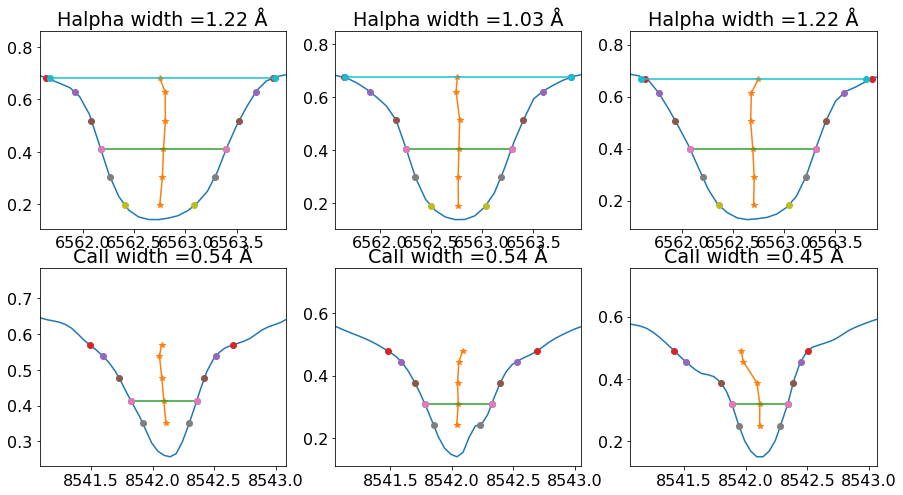

In [14]:
#let's run it for the three pixels identified in previous notebook

from operator import itemgetter
plt.rcParams.update({'font.size': 16})

# Sample points were defined before, let's use those 
sample_x=[522,155,373] # 
sample_y=[133,560,526]

plt.figure(figsize=[15,8])

bis50_idx = np.argmin(np.abs(levels - 0.5))

for i in range(0,3):
    
    (blue_position, red_position, I_level, line_core) = \
                              calc_bisectors(cube_halpha[sample_x[i],sample_y[i],:],ll_halpha, levels,offset_ha)

    ll = (blue_position + red_position) * 0.5
    mean_wavelen = (np.mean(blue_position) + np.mean(red_position)) / 2.

    plt.subplot(2,3,i+1)
    plt.plot(ll_halpha,cube_halpha[sample_x[i],sample_y[i],:])
    plt.plot(ll,I_level,'-*')
    
    plt.plot([(blue_position)[bis50_idx],(red_position)[bis50_idx]],[I_level[bis50_idx],I_level[bis50_idx]],'-o')
    plt.plot([(blue_position),(red_position)],[I_level,I_level],'o')
    
    plt.plot([-offset_ha,offset_ha]+mean_wavelen,[I_level[0],I_level[0]],'-o')

    plt.title('Halpha width ='+ "{:0.2f} Å".format((red_position-blue_position)[bis50_idx])) #
                           #this is the width at "mid point" of the chromospheric core
    plt.xlim([-1.2,1.2] + mean_wavelen)

    # Now Ca
    (blue_position, red_position, I_level, line_core) = \
                                          calc_bisectors(cube_ca[sample_x[i],sample_y[i],:],ll_ca,levels,offset_ca)

    ll=(blue_position + red_position)*0.5
    mean_wavelen = (np.mean(blue_position) + np.mean(red_position)) / 2.

    plt.subplot(2,3,4+i)
    plt.plot(ll_ca,cube_ca[sample_x[i],sample_y[i],:])
    plt.plot(ll[:-1],I_level[:-1],'-*')

    plt.plot([(blue_position)[bis50_idx],(red_position)[bis50_idx]],[I_level[bis50_idx],I_level[bis50_idx]],'-o')

    plt.title('CaII width ='+ "{:0.2f} Å".format(((red_position-blue_position)[bis50_idx])))
    plt.plot([(blue_position[:-1]),(red_position[:-1])],[I_level[:-1],I_level[:-1]],'o')
    plt.xlim([-1,1] + mean_wavelen)


#### Without having to go look at the profile at each pixel, the combined analysis of the bisectors could provide us good insight 

For example the last point has an obvious strange CaII profile: the 2nd bisector from top is very skewed, yet the width of CaII is rather small: this indicates a strong asymmetry. As we already saw, however, Halpha does not change much .... But the width of points 1 and 3 is certainly well above the average - could these be heating events?

Of course, it is a parametrization, so it won't work for every pixel!

We could calculate the whole arrays / multiple levels : this however takes a very long time (dependng on your computer of course). Let's do only Halpha, and only the mid level for now:

In [68]:
# THIS TAKES TOO LONG TO DO IN REAL TIME

import time
start = time.time()

#levels = np.asarray([1.0,0.9,0.7,0.5,0.3,0.1])
levels = np.asarray([0.5])
num_levels = len(levels)

#pixnum = 300
#pixoff = 350
pixnum = 1000
pixoff = 0

bis_blue = np.zeros([pixnum,pixnum,num_levels])
bis_red = np.zeros([pixnum,pixnum,num_levels])
I_levels = np.zeros([pixnum,pixnum,num_levels])
core_pos = np.zeros([pixnum,pixnum])

for i in range(0,pixnum):
    for j in range(0,pixnum):
        (blue_position, red_position, I_level, line_core) = calc_bisectors(cube_halpha[i+pixoff,j+pixoff,:],ll_halpha,levels, offset_ha)

        bis_blue [i,j,:] = blue_position
        bis_red [i,j,:] = red_position
        I_levels[i,j,:] = I_level
        core_pos[i,j] = line_core
        
later = time.time()
print("Execution Time: {:4} sec".format(later - start))

bis50_idx = np.argmin(np.abs(levels - 0.5))
bis50_vel =(bis_blue[:,:,bis50_idx] + bis_red[:,:,bis50_idx])*0.5
bis50_width=(bis_red[:,:,bis50_idx] - bis_blue[:,:,bis50_idx])

Execution Time: 205.4061460494995 sec


This takes about 2-3 min (on Kevin's computer). So, questions ....?


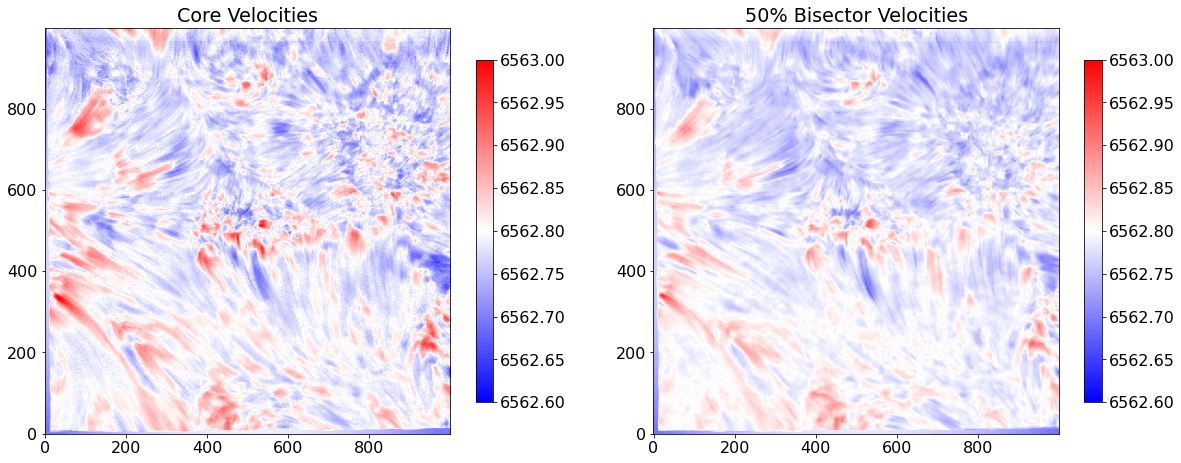

In [72]:
# Let's take a look at the outputs

plt.figure(figsize=[20,9])
plt.subplot(121)

plt.imshow(core_pos[:,:],cmap='bwr',origin='lower',vmin=6562.6,vmax=6563.) # +/- 10 km/s
plt.title("Core Velocities")
plt.colorbar(shrink=0.7)

plt.subplot(122)
plt.imshow(bis50_vel[:,:],cmap='bwr',origin='lower',vmin=6562.6,vmax=6563.) # +/- 10 km/s
plt.title("50% Bisector Velocities")
plt.colorbar(shrink=0.7)


best fit line slope for core to bisector shifts: 0.8520


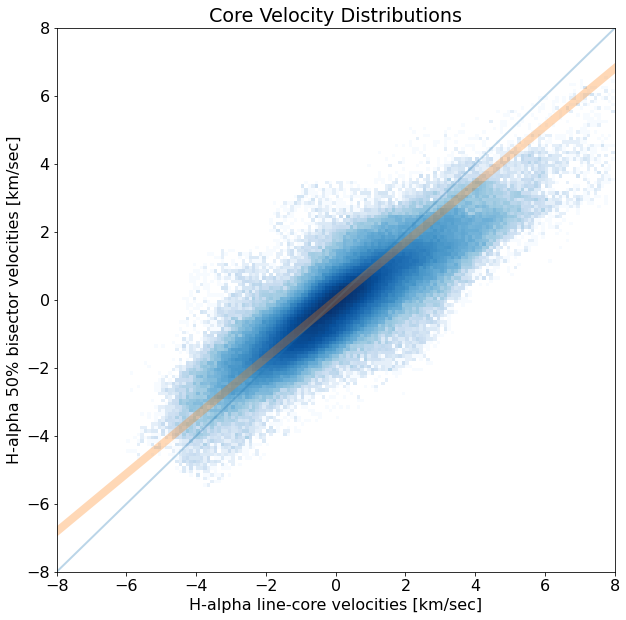

In [73]:
#The core veocity & the bisector velocity at mid-level look very similar ...

plt.figure(figsize=[10,10])
core_halpha_1d = core_pos[cutbox[0]:cutbox[1],cutbox[2]:cutbox[3]].flatten()
bis50_halpha_1d = bis50_vel[cutbox[0]:cutbox[1],cutbox[2]:cutbox[3]].flatten()

bis50_halpha_1d = (bis50_halpha_1d - np.mean(core_halpha_1d))/np.mean(core_halpha_1d) * c
core_halpha_1d = (core_halpha_1d - np.mean(core_halpha_1d))/np.mean(core_halpha_1d) * c

counts,ybins,xbins,image = plt.hist2d(core_halpha_1d,bis50_halpha_1d,bins=160,norm=colors.LogNorm(),range=[[-8,8],[-8,8]], cmap='Blues')
#contours = contour(xbins[1:],ybins[1:],counts,extent=[ybins.min(),ybins.max(),xbins.min(),xbins.max()],linewidths=1, alpha=0.5, levels=[10,100,1000])
#plt.clabel(contours, inline=True, fontsize=8)

plt.title("Core Velocity Distributions")
plt.xlabel("H-alpha line-core velocities [km/sec]")
plt.ylabel("H-alpha 50% bisector velocities [km/sec]")

plt.plot(range(-8,8+1,1),range(-8,8+1,1),alpha=0.3,linewidth=2)

# What is ratio between velocity values from core and bisector position?
# We need to do a linear fit between two arrays, both with measurement errors, 
# but this needs to be done by combining a couple of least-squares regression fits 
# see Isobe et al., 1990, http://adsabs.harvard.edu/doi/10.1086/169390

p = np.polyfit(core_halpha_1d,bis50_halpha_1d,1)
#print("slope: {:0.4f}  intercept: {:0.4f}".format(p[0],p[1]))
slope_xy = p[0]

p = np.polyfit(bis50_halpha_1d,core_halpha_1d,1)
#print("slope: {:0.4f}  intercept: {:0.4f}".format(p[0],p[1]))
slope_yx = p[0]

slope_bis = 1./(slope_xy + slope_yx) * (slope_xy * slope_yx + np.sqrt((1 + slope_xy**2) * (1+slope_yx**2)) - 1 )

#plt.plot(range(-8,8+1,1),(range(-8,8+1,1))*slope_xy,alpha=0.5,linewidth=2)
#plt.plot(range(-8,8+1,1),(range(-8,8+1,1))*slope_yx,alpha=0.5,linewidth=2)
plt.plot(range(-8,8+1,1),(range(-8,8+1,1))*slope_bis,alpha=0.3,linewidth=8)

print("best fit line slope for core to bisector shifts: {:0.4f}".format(slope_bis))


### Now let's look at the bisector width


Mean bisector width: 1.0377


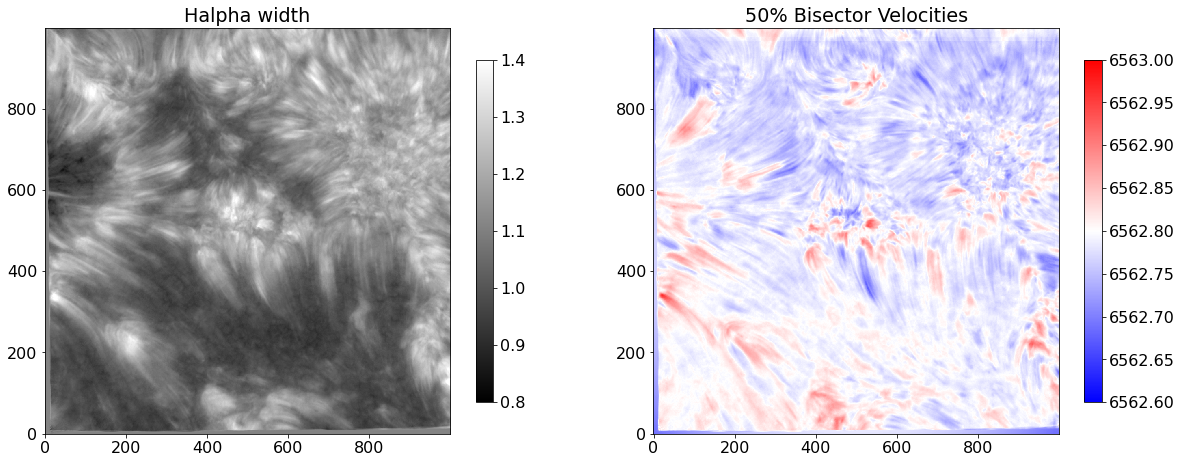

In [74]:
# And finally, let's plot the map of Halpha width

plt.figure(figsize=[20,9])

plt.subplot(121)
plt.imshow(bis50_width[:,:],cmap='gray',origin='lower',vmin=0.8,vmax=1.4) 
plt.title("Halpha width")
plt.colorbar(shrink=0.7)

plt.subplot(122)
plt.imshow(bis50_vel[:,:],cmap='bwr',origin='lower',vmin=6562.6,vmax=6563.) # +/- 9 km/s
plt.title("50% Bisector Velocities")
plt.colorbar(shrink=0.7)

print("Mean bisector width: {:0.4f}".format(np.mean(bis50_width[0:250,:])))


Mean bisector width: 1.0898


Text(0.5, 1.0, 'Halpha Line Parameters')

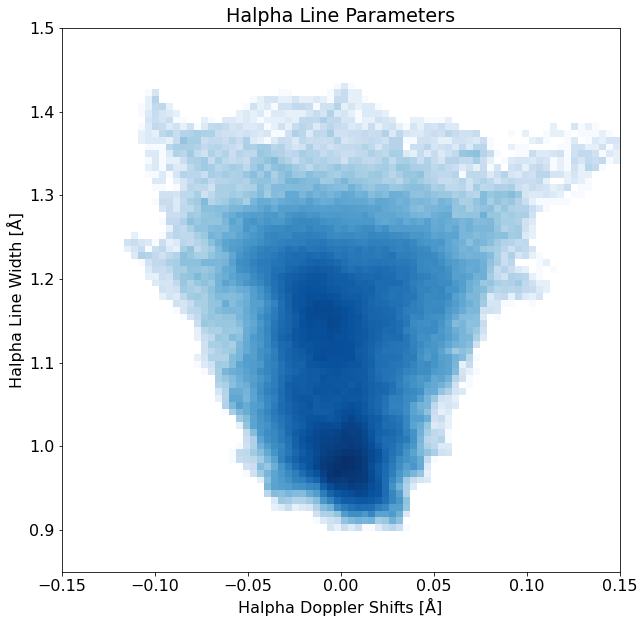

In [75]:
cutbox = [100,900,100,900]
plt.figure(figsize=[10,10])

bis50_halpha_vel_1d = bis50_vel[cutbox[0]:cutbox[1],cutbox[2]:cutbox[3]].flatten()
bis50_halpha_vel_1d = bis50_halpha_vel_1d - np.mean(bis50_vel)

bis50_halpha_wid_1d = bis50_width[cutbox[0]:cutbox[1],cutbox[2]:cutbox[3]].flatten()

print("Mean bisector width: {:0.4f}".format(np.mean(bis50_halpha_wid_1d)))

counts = plt.hist2d(bis50_halpha_vel_1d,bis50_halpha_wid_1d,80,norm=colors.LogNorm(), cmap='Blues', 
                    range=[[-0.15,0.15],[0.85,1.5]])
plt.xlabel("Halpha Doppler Shifts [Å]")
plt.ylabel("Halpha Line Width [Å]")
plt.title("Halpha Line Parameters")


### So, the bisector width and bisector are not well correlated. Even if low line widths have small Doppler velocities, that relationship rapidly breaks down as the line as the line width increases. 
You can see this in the images above, where the dark portions in the width map tend to have lower velocities, but the bases of the fibrils stand out in both the width and velocity maps.

Lets look at a few average profiles to see how the line width and Doppler shifts affect the intensity we observe, especially if we are only looking at one wavelength in the line profile.

Number of summed points:  9355,  9360


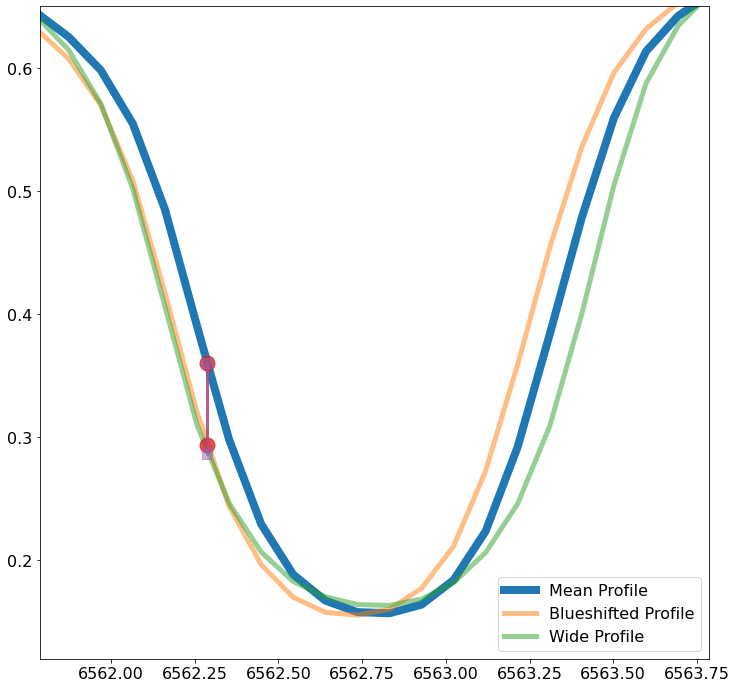

In [76]:
from scipy.interpolate import interp1d

bis50_vel_zero = bis50_vel - np.mean(bis50_vel)

# select points with relatively large Doppler shifts (0.05 mÅ blueward = 2 km/sec blueshift)
#               AND linewidth close to the mean line width (1.07 +/- 0.05 Å)       
vel_points = (bis50_vel_zero < (-0.05)) * (bis50_width < 1.12) * (bis50_width > 1.02)

# instead this will select points with relatively small Doppler shifts (<0.01 mÅ blue/red = < 0.5 km/sec shift)
#               AND linewidth between 1.25 and 1.3 Å)       
bis_points = (abs(bis50_vel_zero) < (0.01)) * (bis50_width > 1.25) * (bis50_width < 1.3)

blueshifted_count = 0
wide_count        = 0

spec_len         = len(cube_halpha[0,0,:])
blueshifted_prof = np.zeros([spec_len])
wide_prof        = np.zeros([spec_len])

for xx in range(0,1000):
    for yy in range(0,1000):
        if vel_points[xx,yy]:
            blueshifted_prof  = blueshifted_prof + cube_halpha[xx,yy,:]
            blueshifted_count = blueshifted_count + 1
        if bis_points[xx,yy]:
            wide_prof  = wide_prof + cube_halpha[xx,yy,:]
            wide_count = wide_count + 1

blueshifted_prof = blueshifted_prof /  blueshifted_count
wide_prof        = wide_prof / wide_count
print("Number of summed points: {:5}, {:5}".format(blueshifted_count, wide_count))

plt.figure(figsize=[12,12])

plt.plot(ll_halpha, mean_spectrum_h,linewidth=8, label='Mean Profile')
plt.xlim([ -1,1] + np.mean(bis50_vel))
plt.ylim([0.12,0.65])

plt.plot(ll_halpha, blueshifted_prof,linewidth=5, alpha=0.5, label='Blueshifted Profile')
plt.plot(ll_halpha, wide_prof,linewidth=5, alpha=0.5, label='Wide Profile')

plt.legend(loc="lower right")

f = interp1d(ll_halpha,mean_spectrum_h, kind='cubic')
mean_spectrum_blueint = f(np.mean(bis50_vel) - 0.5)
fblue = interp1d(ll_halpha, blueshifted_prof, kind='cubic')
bluesft_spectrum_blueint = fblue(np.mean(bis50_vel) - 0.5)
fwide = interp1d(ll_halpha, wide_prof, kind='cubic')
wide_spectrum_blueint = fwide(np.mean(bis50_vel) - 0.5)

plt.plot([-0,0]+np.mean(bis50_vel) - 0.5,[mean_spectrum_blueint,bluesft_spectrum_blueint],'-o',linewidth=3, alpha=0.8, markersize=15)
plt.plot([-0,0]+np.mean(bis50_vel) - 0.5,[mean_spectrum_blueint,wide_spectrum_blueint],'-s',linewidth=3, alpha=0.5, markersize=10)


### So both a broadened profile and a profile with a modest Doppler shift will cause a signifcant decrease in the intensity in the line wing (in this case, about 20% relative to the mean profile).

Let's try to quantify that.

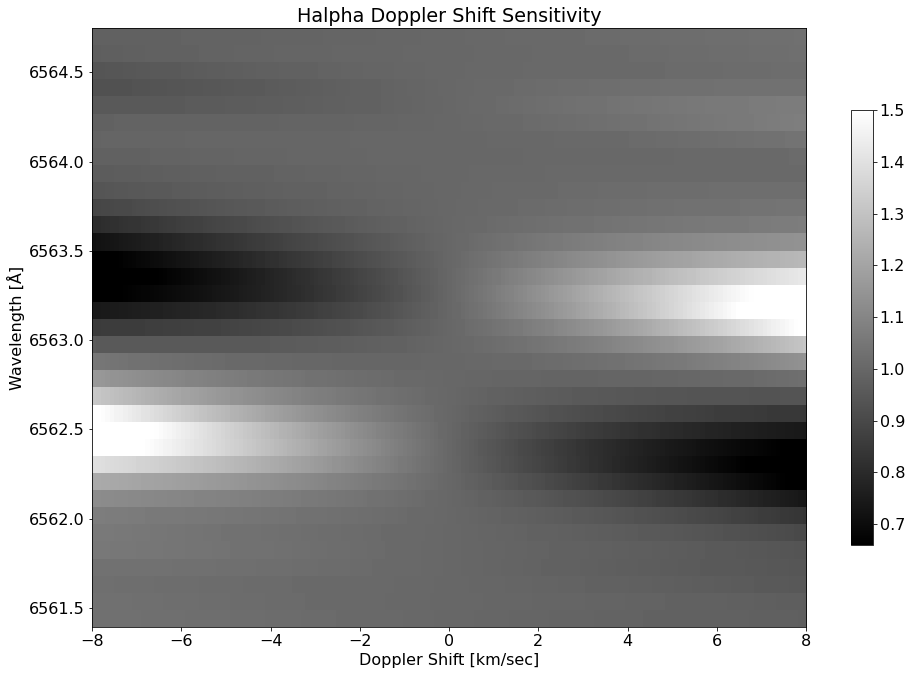

In [77]:
min_sft = -8
max_sft = abs(8)
sft_stp = 0.1
sft_scl = np.arange(min_sft,max_sft+sft_stp,sft_stp)
num_sft = len(sft_scl)

doppler_ratio_map = np.zeros([spec_len,num_sft])

for dop_idx in range(0,num_sft):
    dop_vel = sft_scl[dop_idx] # dopplershift in km/sec
    dop_sft = (dop_vel/c) * np.mean(bis50_vel)
    
    f = interp1d(ll_halpha, mean_spectrum_h, kind='cubic')
    mean_spectrum_sft = f(ll_halpha[5:-5] + dop_sft)
    doppler_ratio_map[5:-5,dop_idx] = mean_spectrum_sft / mean_spectrum_h[5:-5]

plt.figure(figsize=[16,16])

plt.imshow(doppler_ratio_map[5:-5,:],cmap='gray',origin='lower',vmin=0.66,vmax=1.5,aspect=4,extent=[min_sft,max_sft,ll_halpha[5],ll_halpha[-5]]) 
plt.title("Halpha Doppler Shift Sensitivity")
plt.xlabel("Doppler Shift [km/sec]")
plt.ylabel("Wavelength [Å]")

plt.colorbar(shrink=0.5)


#### This plot shows how the intensity changes at each wavelength, relative to the average unshifted profile, for Doppler shifts of $\pm$ 8 km/sec. The biggest contrasts are seen where the line wings are steepest, of course.

Width of mean H-alpha profile  +1.1050 Å


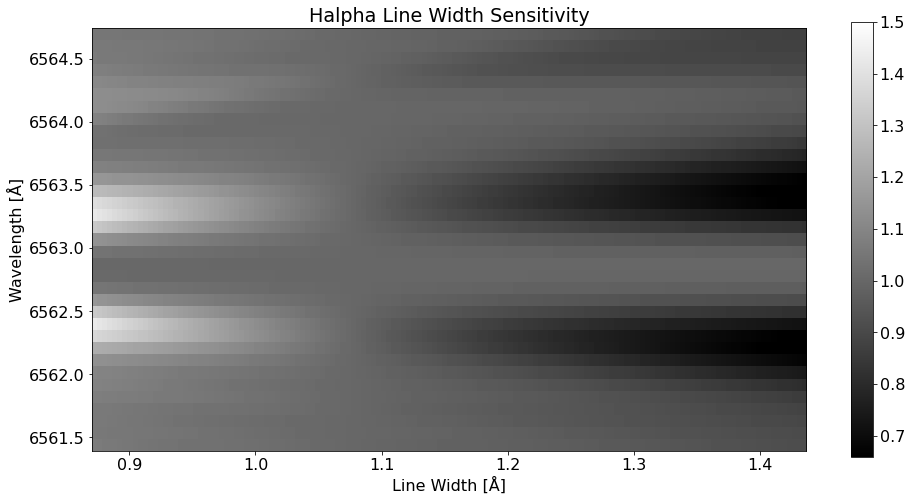

In [78]:
min_width = 0.85
max_width = 1.55
width_stp = 0.005
width_scl = np.arange(min_width,max_width+width_stp,width_stp)
width_num = len(width_scl)
width_ratio_map = np.zeros([spec_len,width_num])
spectrum_width_calc = np.zeros([width_num])

spectrum_width_pos = np.zeros([width_num])

(mean_spectrum_h_blue, mean_spectrum_h_red, I_level, line_core) = calc_bisectors(mean_spectrum_h,ll_halpha, [0.5], offset_ha)
mean_spectrum_h_width = mean_spectrum_h_red - mean_spectrum_h_blue
print("Width of mean H-alpha profile ","{:+0.4f} Å".format(float(mean_spectrum_h_width)))

ll_halpha_zero = ll_halpha - line_core
plt.figure(figsize=[16,16])

for width_idx in range(0,width_num):
    width_out = width_scl[width_idx]
    width_ratio = width_out/mean_spectrum_h_width
    #print(width_out, width_ratio)
    wavescale_cor = ll_halpha_zero / width_ratio
        
    f = interp1d(ll_halpha_zero, mean_spectrum_h, kind='cubic',fill_value='extrapolate')
    mean_spectrum_wide = f(wavescale_cor)
    width_ratio_map[:,width_idx] = mean_spectrum_wide / mean_spectrum_h

    (spectrum_h_blue, spectrum_h_red, I_level, line_core) = calc_bisectors(mean_spectrum_wide,range(0,45), [1.0,0.5], offset_ha/0.095)
    spectrum_width_calc[width_idx] = (spectrum_h_red - spectrum_h_blue)[1] * 0.095
    spectrum_width_pos[width_idx] = line_core

plt.imshow(width_ratio_map[5:-5,:],cmap='gray',origin='lower',vmin=0.66,vmax=1.5,aspect=0.1,extent=[min(spectrum_width_calc),max(spectrum_width_calc),ll_halpha[5],ll_halpha[-5]]) 
plt.colorbar(shrink=0.5)

plt.title("Halpha Line Width Sensitivity")
plt.xlabel("Line Width [Å]")
a=plt.ylabel("Wavelength [Å]")


#### A similar calculation of intensity changes at each wavelength, relative to the average unshifted profile, for a line that is broadened over the observed range of line widths. The relative contrasts are comparable to what is seen due to Doppler shifts.

Of course there can be a combination of line width changes and Doppler shifts, which can all produce some contrast ratio. We can calculate and display that for one wavelength.

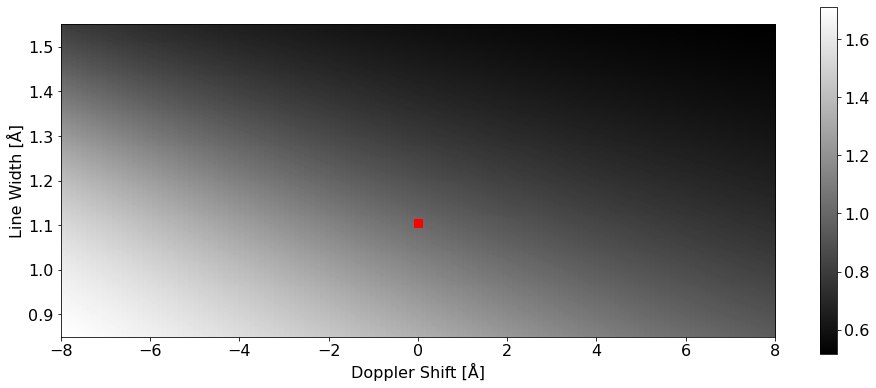

In [88]:
wing_wave = -0.5

ratio_map = np.zeros([num_sft,width_num])

f = interp1d(ll_halpha_zero, mean_spectrum_h, kind='cubic', fill_value='extrapolate')
reference_wing_int = f(wing_wave)

for dop_idx in range(0,num_sft):
    dop_vel = sft_scl[dop_idx] # dopplershift in km/sec
    dop_sft = (dop_vel/c) * np.mean(bis50_vel)

    for width_idx in range(0,width_num):
        width_out = width_scl[width_idx]
        width_ratio = width_out/mean_spectrum_h_width
        wavescale_cor = ll_halpha_zero / width_ratio
        
        f = interp1d(ll_halpha_zero, mean_spectrum_h, kind='cubic', fill_value='extrapolate')
        mean_spectrum_wide = f(wavescale_cor)
    
        f = interp1d(ll_halpha_zero, mean_spectrum_wide, kind='cubic', fill_value='extrapolate')
        mean_spectrum_sft = f(ll_halpha_zero + dop_sft)        
        
        f = interp1d(ll_halpha_zero, mean_spectrum_sft, kind='cubic', fill_value='extrapolate')
        ratio_map[dop_idx,width_idx] = f(wing_wave)


plt.figure(figsize=[16,16])
     
plt.imshow(ratio_map[:,:]/reference_wing_int,cmap='gray',origin='lower',aspect=10,extent=[min(sft_scl),max(sft_scl),min(width_scl),max(width_scl)]) 

plt.plot(0,mean_spectrum_h_width,'s',markersize=8,color='red')
plt.colorbar(shrink=0.4)

plt.ylabel("Line Width [Å]")
a=plt.xlabel("Doppler Shift [Å]")

#contours = contour(width_scl,sft_scl,ratio_map[:,:],extent=[min(sft_scl),max(sft_scl),min(width_scl),max(width_scl)],linewidths=1, alpha=0.5)
#plt.clabel(contours, inline=True, fontsize=8)


####  Are these contrast values consistent with the intensities we actually observe in the wing of the profile?



Text(0.5, 1.0, 'Halpha Wing Contrast Distribution')

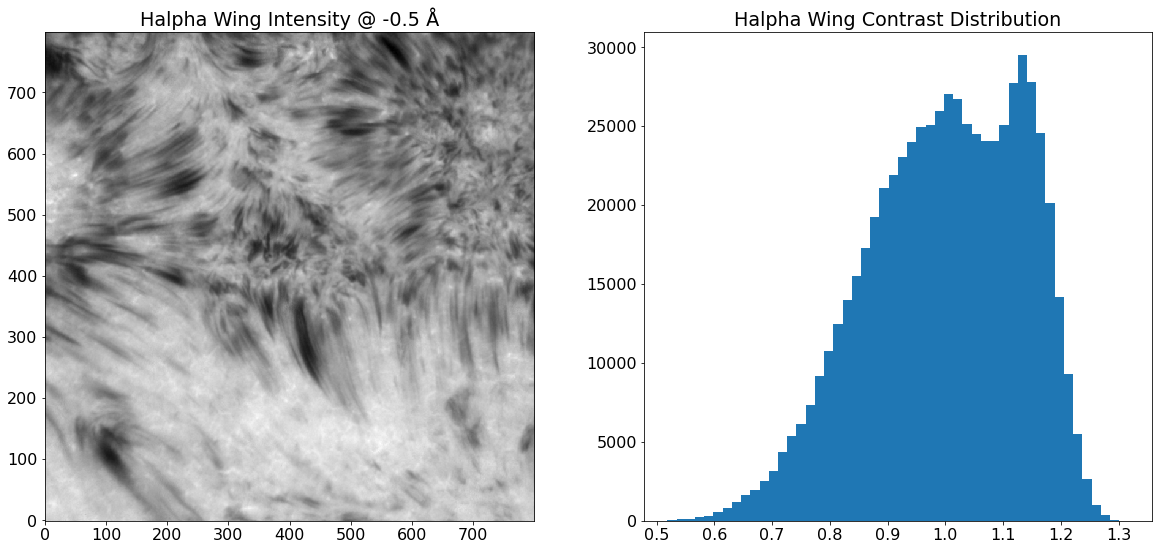

In [92]:
wingidx = np.argmin(abs(ll_halpha - l_center_mean_ha - wing_wave))

wingim = cube_halpha[cutbox[0]:cutbox[1],cutbox[2]:cutbox[3],wingidx]
wingim_norm = wingim / np.mean(wingim)

plt.figure(figsize=[20,9])

plt.subplot(121)
plt.imshow(wingim_norm,cmap='gray')
plt.title("Halpha Wing Intensity @ -0.5 Å")

plt.subplot(122)
counts = plt.hist(wingim_norm.flatten(),bins=50)
plt.title("Halpha Wing Contrast Distribution")


Yes, the range of observed contrasts in the wing of H-alpha are consistent with a combination of velocities of $\pm$ 8 km/sec (i.e. below the sound speed) and a typical broadening of the line profile. There can be other explanations as well for these contrast structures, but Occam's razor suggests we should be careful!

####  Why does the H-alpha profile change in width? 

Most of the broad profiles appear to coincide with the "fibrils" well visible in the flow map and with **portions** of the fibrils present in the line core intensity. 

We saw that a hotter chromospheric atmosphere (within limits) indeed produces a broader line (until it gets too hot and the amount of neutral hydrogen starts to decrease. This was examined by [Cauzzi et al. 2009](https://ui.adsabs.harvard.edu/abs/2009A&A...503..577C/abstract), who calculated the temperature range needed to produce the observed range of H$\alpha$ line widths, coming up with an estimate of 5,000-60,000 K.

More recently, [Molnar et al 2019](https://ui.adsabs.harvard.edu/abs/2019ApJ...881...99M/abstract) using simultaneous ALMA data (which measure the millimeter continuum intensity and are a more direct probe of the thermal conditions of the chromosphere) and H$\alpha$ line width measurements, found that there was a strong correlation between these two diagnostics. But the temperatures in the ALMA data only ranged from 6,000 to 12,000 K. They concluded that the observed changes in the H-alpha line width was due instead to opacity broadening as the chromospheric conditions (especially electron density) changed.

So there is good information in the chromospheric lines, but there are always challenges (and ambiguities) in the interpretation!
